In [2]:
import numpy as np
import os
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from typing import Optional
from sklearn.model_selection import BaseCrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score

lookahead = 10
n_splits=5
pct_embargo=0.01
train_cutoff_date = '2023-11-01'
targets = ["ReturnBin10", "ReturnBinQuantile", "ReturnBin10_manual_bell"]
#targets = ["ReturnBinQuantile"]
columns_to_exclude = [
    'DateTime', 'Open', 'High', 'Low', 'Close',
    'Volume', 'Hour', 'DayOfWeek', 'Target'
]

class PurgedKFold(BaseCrossValidator):
    def __init__(self, n_splits=3, t1: Optional[np.ndarray] = None, pctEmbargo: float = 0.0):
        """
        Parameters
        ----------
        n_splits : int
            Number of folds.
        t1 : np.ndarray
            A Series/array of shape (n_samples,) where each entry t1[i]
            is the 'last time' that the label at row i depends on.
        pctEmbargo : float
            Percentage (0.0 to 1.0) of the dataset to 'embargo' on the right side.
        """
        super().__init__()
        self.n_splits = n_splits
        self.t1 = t1
        self.pctEmbargo = pctEmbargo

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if X.shape[0] != len(self.t1):
            raise ValueError("X and t1 must have the same number of rows")

        indices = np.arange(X.shape[0])
        n_samples = X.shape[0]
        mbrg = int(n_samples * self.pctEmbargo)

        # Split indices into n_splits contiguous folds
        test_starts = [
            (fold[0], fold[-1] + 1)
            for fold in np.array_split(indices, self.n_splits)
        ]

        for i, j in test_starts:
            test_indices = indices[i:j]

            # t0 is the "start time" index for the test fold
            t0 = i

            # The max label value in the test set
            maxTestLabelValue = self.t1[test_indices].max()

            # Find last location of that maxTestLabelValue in t1
            maxTestLabelIdx_array = np.where(self.t1 == maxTestLabelValue)[0]
            if len(maxTestLabelIdx_array) == 0:
                # In case we never find it (edge case)
                maxTestLabelIndex = j
            else:
                maxTestLabelIndex = maxTestLabelIdx_array[-1]

            # Left train set
            train_indices_left = np.where(self.t1 <= t0)[0]

            # Right train set (embargo)
            if maxTestLabelIndex < n_samples:
                train_indices_right = indices[maxTestLabelIndex + mbrg:]
                train_indices = np.concatenate((train_indices_left, train_indices_right))
            else:
                train_indices = train_indices_left

            yield train_indices, test_indices

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1]
}



estimators = {}

for target in targets:
    wandb.init(project="edo", name=f"xgboost_hparam_f1macro_{target}")
    print("=" * 60)
    print(f"Training/Testing for target: {target}")
    

    data_path = os.path.join("eDo", "data", f"04-{target}.csv")
    df = pd.read_csv(data_path, parse_dates=["DateTime"])
    df.sort_values("DateTime", inplace=True)
    

    df_IS = df[df['DateTime'] < train_cutoff_date].dropna().iloc[:-lookahead].copy()
    X_IS = df_IS.drop(columns=columns_to_exclude)
    y_IS = df_IS["Target"]
    

    #df_OOS = df[(df['DateTime'] >= train_cutoff_date) & (df['DateTime'] < '2023-12-01')].dropna().copy()
    df_OOS = df[(df['DateTime'] >= train_cutoff_date)].dropna().copy()
    X_OOS = df_OOS.drop(columns=columns_to_exclude)
    y_OOS = df_OOS["Target"]

    t1_IS = (X_IS.index.to_series() + lookahead).to_numpy()

    # Set up PurgedKFold
    purged_cv = PurgedKFold(n_splits=n_splits, t1=t1_IS, pctEmbargo=pct_embargo)

    xgb_estimator = XGBClassifier(
        random_state=42,
        num_class=len(np.unique(y_IS)),
        objective='multi:softprob'
    )


    grid_search = GridSearchCV(
        estimator=xgb_estimator,
        param_grid=param_grid,
        #scoring=make_scorer(accuracy_score),
        scoring=make_scorer(f1_score, average='macro'), 
        cv=purged_cv,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_IS, y_IS)

    best_score_ = grid_search.best_score_
    best_params_ = grid_search.best_params_
    best_estimator_ = grid_search.best_estimator_

    print(f"Best CV Score for {target}: {best_score_:.4f}")
    print(f"Best Params for {target}: {best_params_}")

    preds_OOS = best_estimator_.predict(X_OOS)

    acc_OOS = accuracy_score(y_OOS, preds_OOS)
    f1_micro_OOS = f1_score(y_OOS, preds_OOS, average='micro')
    f1_macro_OOS = f1_score(y_OOS, preds_OOS, average='macro')

    print(f"OOS Accuracy for {target}: {acc_OOS:.4f}")
    print(f"OOS F1 (micro) for {target}: {f1_micro_OOS:.4f}")
    print(f"OOS F1 (macro) for {target}: {f1_macro_OOS:.4f}")


    estimators[target] = {
        'best_estimator': best_estimator_,
        'X_IS': X_IS,
        'y_IS': y_IS,
        'X_OOS': X_OOS,
        'y_OOS': y_OOS
    }

    wandb.log({
        f"best_score_cv": best_score_,
        f"best_params": best_params_,
        f"oos_accuracy": acc_OOS,
        f"oos_f1_micro": f1_micro_OOS,
        f"oos_f1_macro": f1_macro_OOS,
    })

    # log stats
    for data_part in ["IS", "OOS"]:
        print("\n====================================================")
        print(f"Analytics for {data_part} - Target: {target}")
        print("====================================================")

        # Retrieve data
        X = estimators[target][f'X_{data_part}']
        y = estimators[target][f'y_{data_part}']

        # Retrieve the best estimator
        xgb_estimator = estimators[target]['best_estimator']
        y_pred = xgb_estimator.predict(X)

        # Accuracy / Classification Report
        acc = accuracy_score(y, y_pred)
        report_str = classification_report(y, y_pred)

        print("Accuracy:", acc)
        print(report_str)

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)
        fig_cm, ax_cm = plt.subplots(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
        ax_cm.set_title(f"Confusion Matrix: {data_part}")
        ax_cm.set_xlabel("Predicted")
        ax_cm.set_ylabel("True")
        
        # Log confusion matrix as an image
        wandb.log({f"conf_matrix_{data_part}": wandb.Image(fig_cm)})

        plt.close(fig_cm)  # Close to avoid overlapping figures in notebooks

        # Feature importances
        feature_importances = xgb_estimator.feature_importances_
        fig_imp, ax_imp = plt.subplots(figsize=(8,5))
        ax_imp.bar(range(len(feature_importances)), feature_importances, color='skyblue')
        ax_imp.set_xticks(range(len(feature_importances)))
        ax_imp.set_xticklabels(X.columns, rotation=90)
        ax_imp.set_title(f"Feature Importances: {data_part}")

        # Log feature importances as an image
        wandb.log({f"feature_importances_{data_part}": wandb.Image(fig_imp)})

        plt.close(fig_imp)


        # cv stats
        if data_part == "IS":
            t1 = (X.index.to_series() + lookahead).to_numpy()
            purged_cv = PurgedKFold(n_splits=n_splits, t1=t1, pctEmbargo=pct_embargo)

            accuracy = cross_val_score(
                xgb_estimator, X, y, cv=purged_cv, scoring='accuracy'
            )

            f1_micro = cross_val_score(
                xgb_estimator, X, y, cv=purged_cv, scoring='f1_micro'
            )


            f1_macro = cross_val_score(
                xgb_estimator, X, y, cv=purged_cv, scoring='f1_macro'
            )


            scores_df = pd.DataFrame({
                'Accuracy': accuracy,
                'F1_micro': f1_micro,
                'F1_macro': f1_macro
            })

            fig_box, ax_box = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=scores_df, ax=ax_box)
            sns.stripplot(data=scores_df, color='black', alpha=0.5, ax=ax_box)
            ax_box.set_title(f"{data_part} Cross-Validation Score Distribution")
            ax_box.set_ylabel("Score")
            # Log the figure
            wandb.log({f"{data_part}_cv_scores_boxplot": wandb.Image(fig_box)})
            plt.close(fig_box)

            fold_indices = np.arange(len(accuracy))
            width = 0.25
            fig_bar, ax_bar = plt.subplots(figsize=(8, 5))
            ax_bar.bar(fold_indices - width, accuracy, width=width, label='Accuracy', color='skyblue')
            ax_bar.bar(fold_indices, f1_micro, width=width, label='F1_micro', color='salmon')
            ax_bar.bar(fold_indices + width, f1_macro, width=width, label='F1_macro', color='limegreen')

            ax_bar.set_xticks(fold_indices)
            ax_bar.set_xticklabels([f'Fold {i+1}' for i in fold_indices])
            ax_bar.set_title(f"{data_part} Cross-Validation Scores by Fold")
            ax_bar.set_xlabel("Fold")
            ax_bar.set_ylabel("Score")
            ax_bar.set_ylim(0, 1)
            ax_bar.legend()

            # Log the figure
            wandb.log({f"{data_part}_cv_scores_bar": wandb.Image(fig_bar)})
            plt.close(fig_bar)

    wandb.finish()


Training/Testing for target: ReturnBin10
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV Score (Accuracy) for ReturnBin10: 0.2104
Best Params for ReturnBin10: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500}
OOS Accuracy for ReturnBin10: 0.7727
OOS F1 (micro) for ReturnBin10: 0.7727
OOS F1 (macro) for ReturnBin10: 0.2039

Analytics for IS - Target: ReturnBin10
Accuracy: 0.94826244813278
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      0.65      0.78      1088
           2       0.94      1.00      0.97     12750
           3       1.00      0.65      0.79      1131
           4       1.00      0.96      0.98       247

    accuracy                           0.95     15424
   macro avg       0.99      0.85      0.90     15424
weighted avg       0.95      0.95      0.94     15424


Analytics for OOS - Target: ReturnBin10
Accuracy: 0.

best_score_cv,▁
oos_accuracy,▁
oos_f1_macro,▁
oos_f1_micro,▁
best_score_cv,0.21036
oos_accuracy,0.77275
oos_f1_macro,0.20394
oos_f1_micro,0.77275


Training/Testing for target: ReturnBinQuantile
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV Score (Accuracy) for ReturnBinQuantile: 0.2547
Best Params for ReturnBinQuantile: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500}
OOS Accuracy for ReturnBinQuantile: 0.2441
OOS F1 (micro) for ReturnBinQuantile: 0.2441
OOS F1 (macro) for ReturnBinQuantile: 0.2240

Analytics for IS - Target: ReturnBinQuantile
Accuracy: 0.4974066390041494
              precision    recall  f1-score   support

           0       0.49      0.59      0.54      3093
           1       0.46      0.43      0.44      3170
           2       0.52      0.61      0.56      3404
           3       0.51      0.31      0.39      2898
           4       0.51      0.52      0.52      2859

    accuracy                           0.50     15424
   macro avg       0.50      0.49      0.49     15424
weighted avg       0.50      0.50      0.49     15424


Analyt

best_score_cv,▁
oos_accuracy,▁
oos_f1_macro,▁
oos_f1_micro,▁
best_score_cv,0.25472
oos_accuracy,0.24407
oos_f1_macro,0.224
oos_f1_micro,0.24407


Training/Testing for target: ReturnBin10_manual_bell
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV Score (Accuracy) for ReturnBin10_manual_bell: 0.1525
Best Params for ReturnBin10_manual_bell: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}
OOS Accuracy for ReturnBin10_manual_bell: 0.2427
OOS F1 (micro) for ReturnBin10_manual_bell: 0.2427
OOS F1 (macro) for ReturnBin10_manual_bell: 0.1543

Analytics for IS - Target: ReturnBin10_manual_bell
Accuracy: 0.9491701244813278
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       0.99      0.96      0.98      1088
           2       0.98      0.92      0.95      2091
           3       0.91      0.98      0.94      4466
           4       0.93      0.97      0.95      4241
           5       0.99      0.87      0.93      1952
           6       0.99      0.91      0.95      1131
           7       1.

best_score_cv,▁
oos_accuracy,▁
oos_f1_macro,▁
oos_f1_micro,▁
best_score_cv,0.15246
oos_accuracy,0.24273
oos_f1_macro,0.15435
oos_f1_micro,0.24273


# In sample stats





= IS Target: ReturnBin10
Accuracy: 0.94826244813278
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      0.65      0.78      1088
           2       0.94      1.00      0.97     12750
           3       1.00      0.65      0.79      1131
           4       1.00      0.96      0.98       247

    accuracy                           0.95     15424
   macro avg       0.99      0.85      0.90     15424
weighted avg       0.95      0.95      0.94     15424



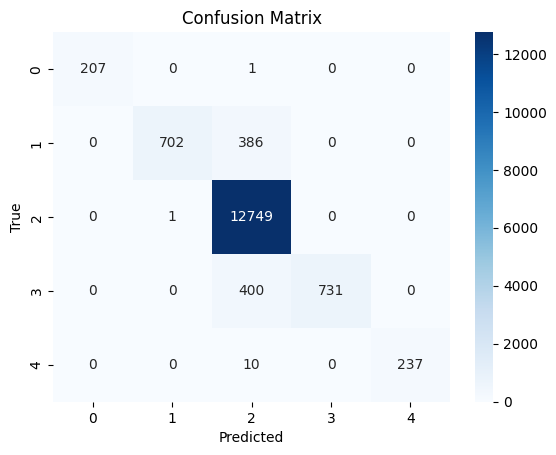

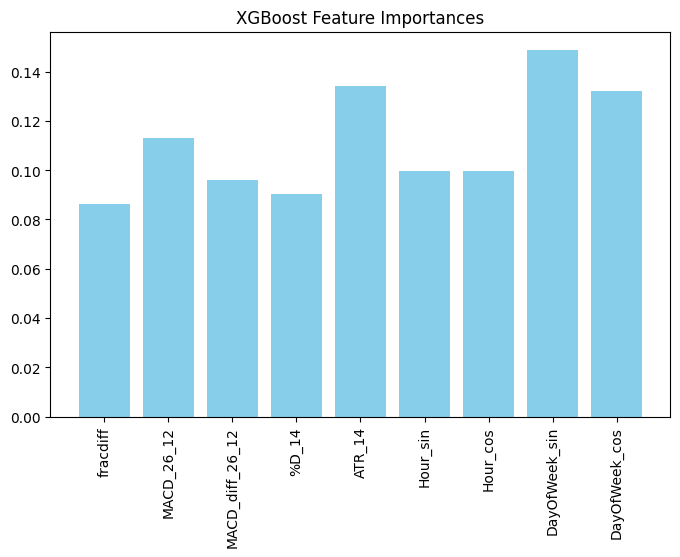





= IS Target: ReturnBinQuantile
Accuracy: 0.4974066390041494
              precision    recall  f1-score   support

           0       0.49      0.59      0.54      3093
           1       0.46      0.43      0.44      3170
           2       0.52      0.61      0.56      3404
           3       0.51      0.31      0.39      2898
           4       0.51      0.52      0.52      2859

    accuracy                           0.50     15424
   macro avg       0.50      0.49      0.49     15424
weighted avg       0.50      0.50      0.49     15424



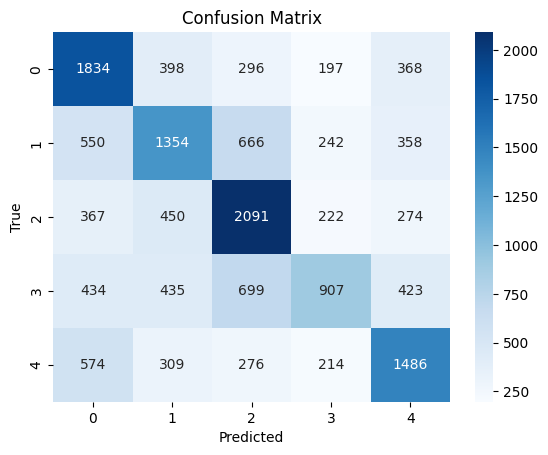

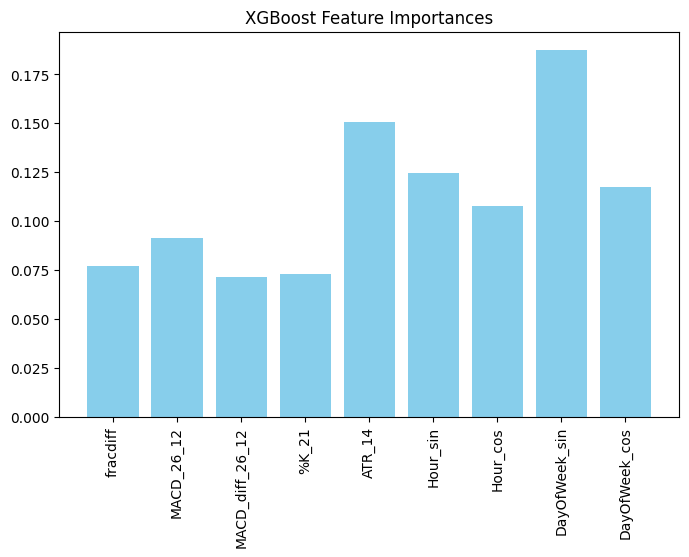





= IS Target: ReturnBin10_manual_bell
Accuracy: 0.9491701244813278
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       0.99      0.96      0.98      1088
           2       0.98      0.92      0.95      2091
           3       0.91      0.98      0.94      4466
           4       0.93      0.97      0.95      4241
           5       0.99      0.87      0.93      1952
           6       0.99      0.91      0.95      1131
           7       1.00      0.98      0.99       247

    accuracy                           0.95     15424
   macro avg       0.98      0.95      0.96     15424
weighted avg       0.95      0.95      0.95     15424



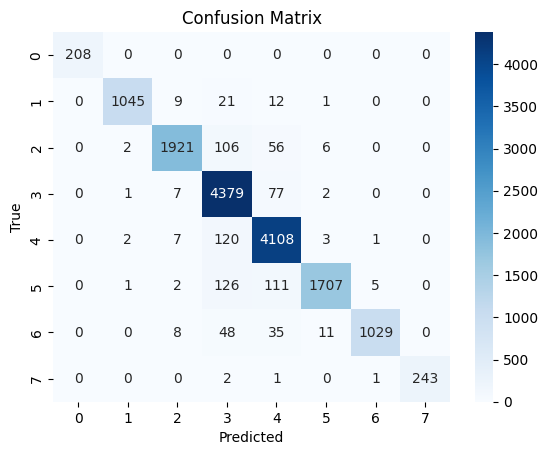

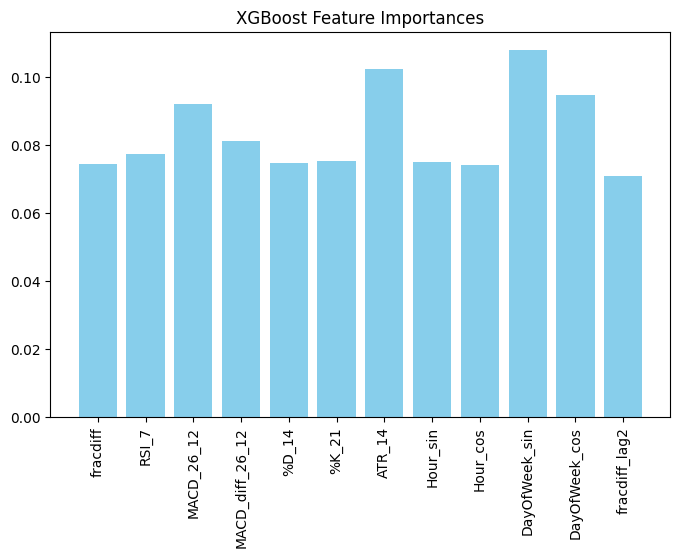





= OOS Target: ReturnBin10
Accuracy: 0.7727460284712193
              precision    recall  f1-score   support

           0       0.01      0.01      0.01        75
           1       0.06      0.04      0.05       643
           2       0.83      0.93      0.88      7993
           3       0.17      0.04      0.07       891
           4       0.01      0.01      0.01        92

    accuracy                           0.77      9694
   macro avg       0.22      0.21      0.20      9694
weighted avg       0.71      0.77      0.73      9694



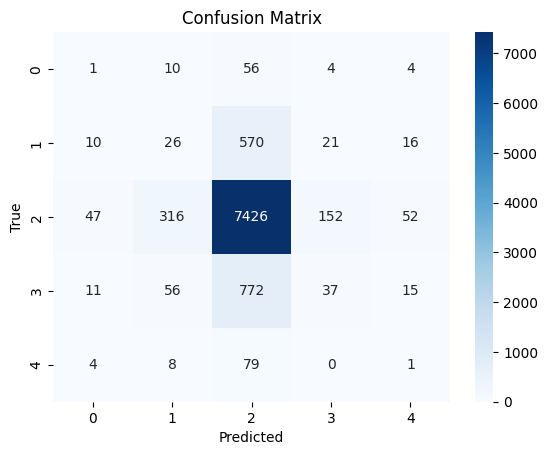

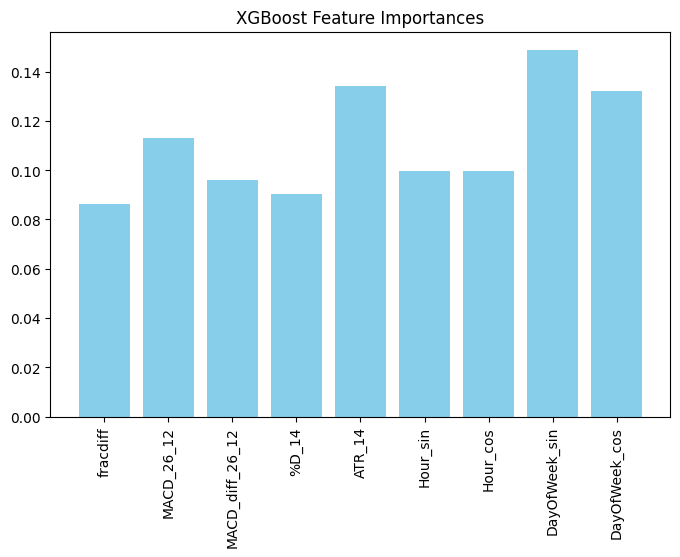





= OOS Target: ReturnBinQuantile
Accuracy: 0.24406849597689292
              precision    recall  f1-score   support

           0       0.22      0.47      0.30      1929
           1       0.21      0.14      0.17      1857
           2       0.29      0.12      0.16      1622
           3       0.28      0.14      0.19      2128
           4       0.27      0.33      0.30      2158

    accuracy                           0.24      9694
   macro avg       0.25      0.24      0.22      9694
weighted avg       0.25      0.24      0.23      9694



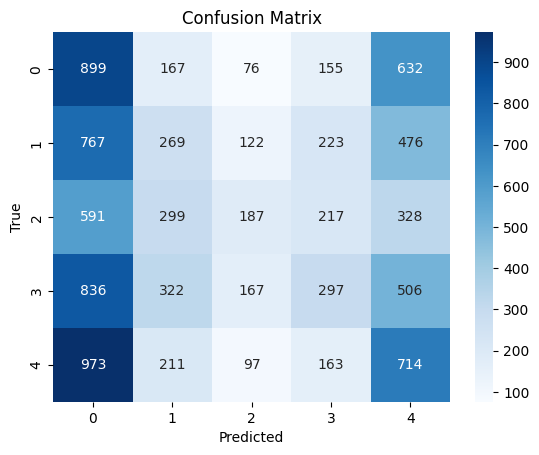

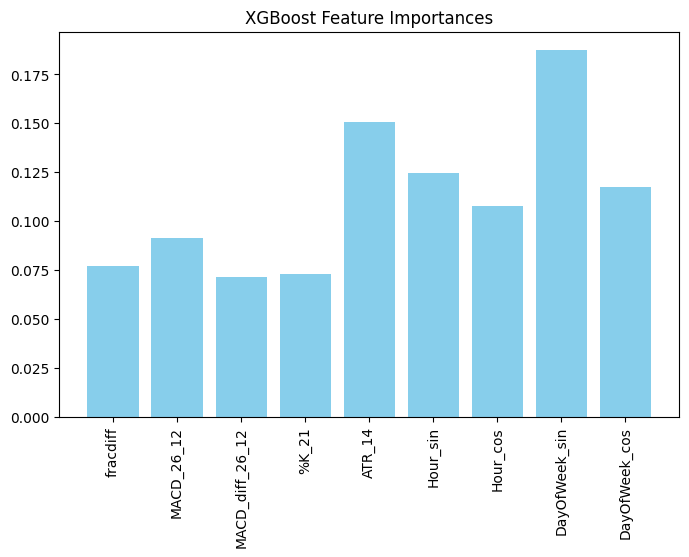





= OOS Target: ReturnBin10_manual_bell
Accuracy: 0.2427274602847122
              precision    recall  f1-score   support

           0       0.02      0.03      0.02        75
           1       0.08      0.09      0.09       643
           2       0.16      0.14      0.15      1410
           3       0.30      0.33      0.31      2435
           4       0.35      0.37      0.36      2550
           5       0.17      0.16      0.16      1598
           6       0.17      0.11      0.13       891
           7       0.01      0.01      0.01        92

    accuracy                           0.24      9694
   macro avg       0.16      0.15      0.15      9694
weighted avg       0.24      0.24      0.24      9694



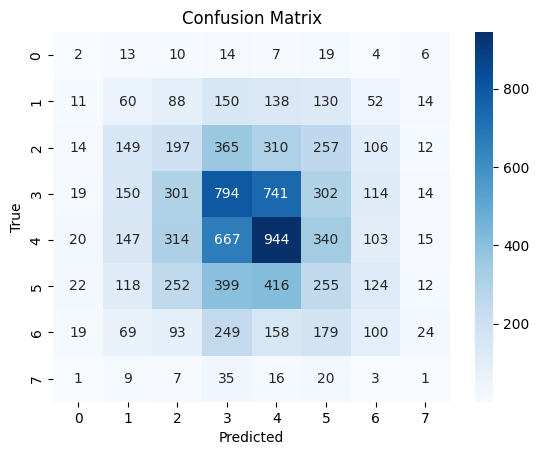

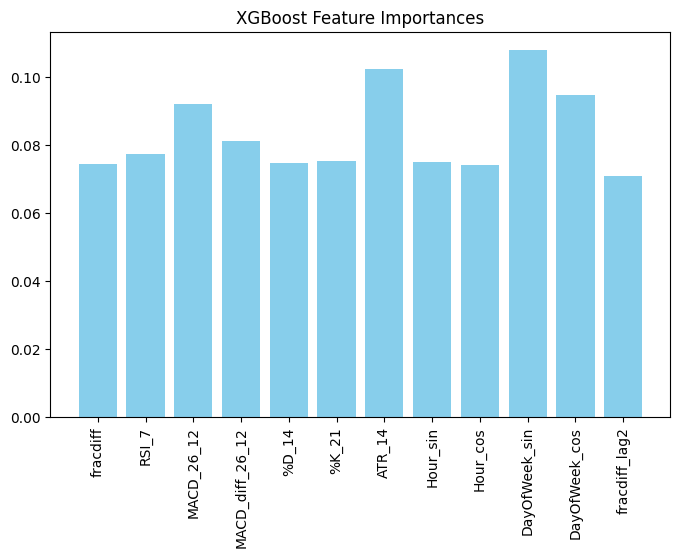

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


for data_part in ["IS", "OOS"]:
    for target in targets:
        print("\n\n\n")
        print("==============================================================================================")
        print("=", data_part, "Target:", target)
        print("==============================================================================================")
        X = estimators[target][f'X_{data_part}']
        y = estimators[target][f'y_{data_part}']
        xgb_estimator = estimators[target]['best_estimator']
        y_pred = xgb_estimator.predict(X)

        # Print classification metrics
        print("Accuracy:", accuracy_score(y, y_pred))
        print(classification_report(y, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        feature_importances = xgb_estimator.feature_importances_
        plt.figure(figsize=(8,5))
        plt.bar(range(len(feature_importances)), feature_importances, color='skyblue')
        plt.xticks(range(len(feature_importances)), X.columns, rotation=90)
        plt.title("XGBoost Feature Importances")
        plt.show()

# Cross validation score





= IS Target: ReturnBin10
Cross-validation accuracy scores: [0.65964344 0.71636953 0.85251216 0.82398703 0.92574578]
Mean CV Accuracy: 0.7956515880573546
Cross-validation f1_micro scores: [0.65964344 0.71636953 0.85251216 0.82398703 0.92574578]
Mean CV Accuracy: 0.7956515880573546
Cross-validation accuracy f1_macro: [0.23945349 0.19084562 0.18918959 0.18287387 0.24941811]
Mean CV Accuracy: 0.21035613621744292


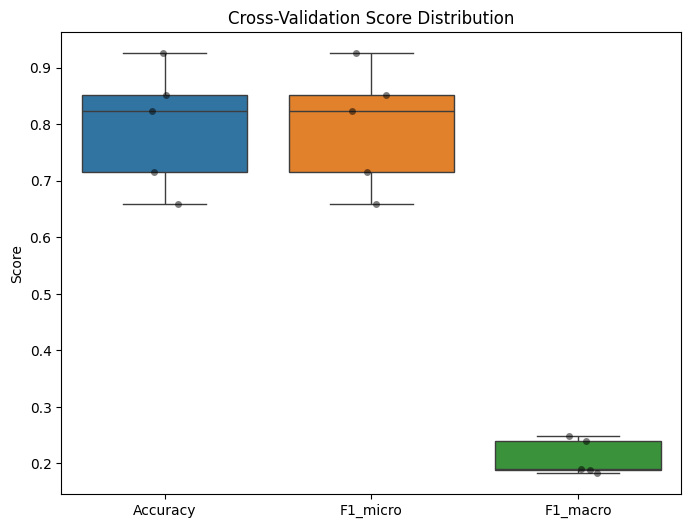

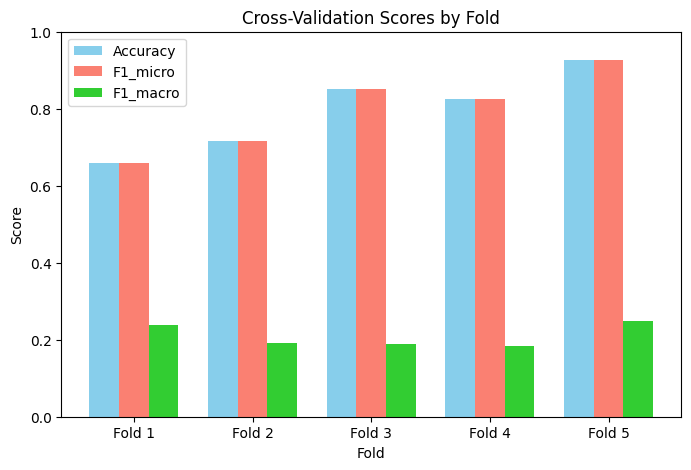





= IS Target: ReturnBinQuantile
Cross-validation accuracy scores: [0.26645057 0.23435981 0.2897893  0.26709887 0.3038262 ]
Mean CV Accuracy: 0.2723049482139216
Cross-validation f1_micro scores: [0.26645057 0.23435981 0.2897893  0.26709887 0.3038262 ]
Mean CV Accuracy: 0.2723049482139216
Cross-validation accuracy f1_macro: [0.22425363 0.22582042 0.27958818 0.25751638 0.28643749]
Mean CV Accuracy: 0.25472322201995057


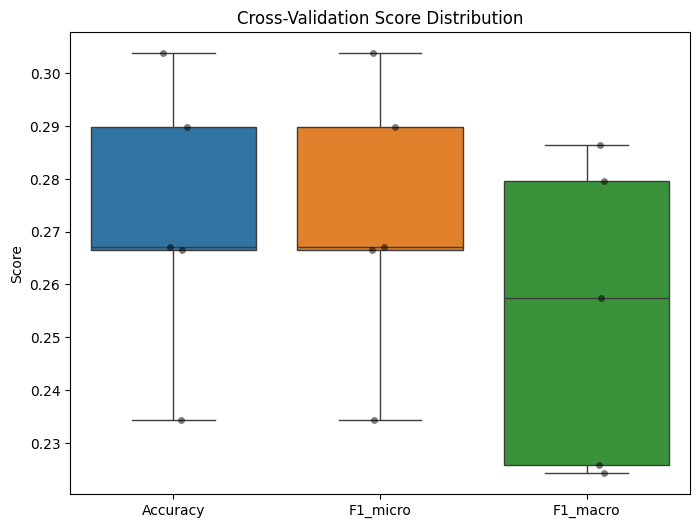

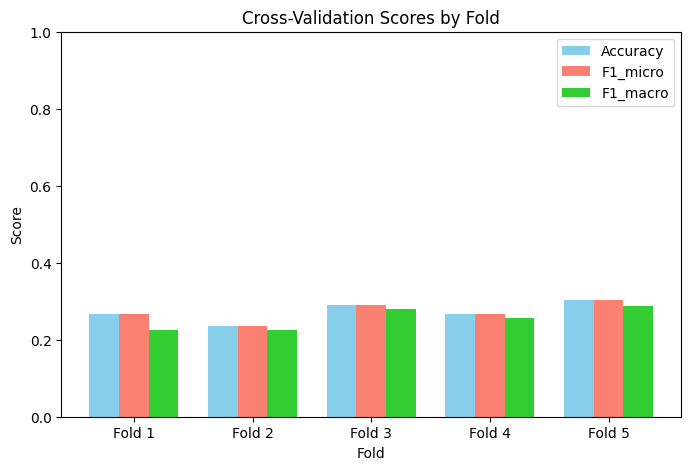





= IS Target: ReturnBin10_manual_bell
Cross-validation accuracy scores: [0.20518639 0.21069692 0.31896272 0.28719611 0.35376135]
Mean CV Accuracy: 0.27516069765633044
Cross-validation f1_micro scores: [0.20518639 0.21069692 0.31896272 0.28719611 0.35376135]
Mean CV Accuracy: 0.27516069765633044
Cross-validation accuracy f1_macro: [0.16812624 0.13179413 0.16148683 0.13105618 0.16986041]
Mean CV Accuracy: 0.1524647565452555


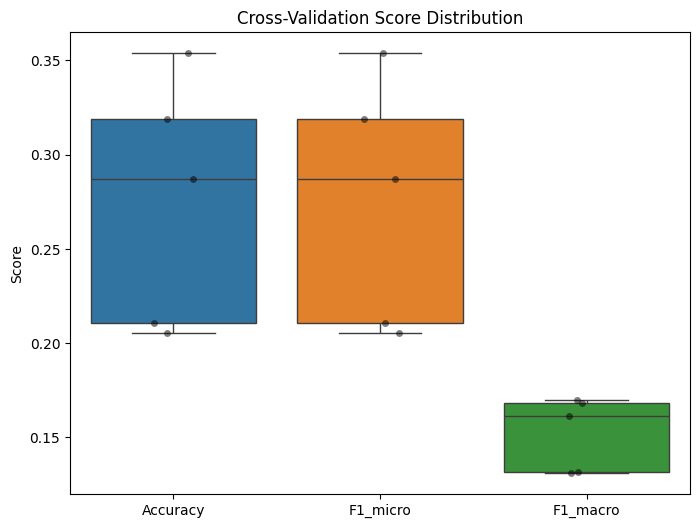

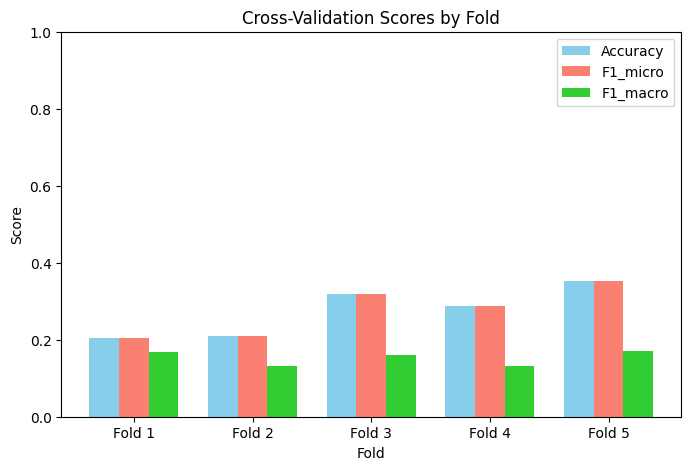

In [4]:
from sklearn.model_selection import cross_val_score


for data_part in ["IS"]:
    for target in targets:
        print("\n\n\n")
        print("==============================================================================================")
        print("=", data_part, "Target:", target)
        print("==============================================================================================")
        X = estimators[target][f'X_{data_part}']
        y = estimators[target][f'y_{data_part}']
        xgb_estimator = estimators[target]['best_estimator']
                
        t1 = (X.index.to_series() + lookahead).to_numpy()
        purged_cv = PurgedKFold(n_splits=n_splits, t1=t1, pctEmbargo=pct_embargo)

        accuracy = cross_val_score(
            xgb_estimator, X, y, cv=purged_cv, scoring='accuracy'
        )
        print("Cross-validation accuracy scores:", accuracy)
        print("Mean CV Accuracy:", accuracy.mean())

        f1_micro = cross_val_score(
            xgb_estimator, X, y, cv=purged_cv, scoring='f1_micro'
        )
        print("Cross-validation f1_micro scores:", f1_micro)
        print("Mean CV Accuracy:", f1_micro.mean())


        f1_macro = cross_val_score(
            xgb_estimator, X, y, cv=purged_cv, scoring='f1_macro'
        )
        print("Cross-validation accuracy f1_macro:", f1_macro)
        print("Mean CV Accuracy:", f1_macro.mean())


        scores_df = pd.DataFrame({
            'Accuracy': accuracy,
            'F1_micro': f1_micro,
            'F1_macro': f1_macro
        })

        plt.figure(figsize=(8, 6))
        sns.boxplot(data=scores_df)
        sns.stripplot(data=scores_df, color='black', alpha=0.5)
        plt.title("Cross-Validation Score Distribution")
        plt.ylabel("Score")
        plt.show()


        fold_indices = np.arange(len(accuracy))
        width = 0.25
        plt.figure(figsize=(8, 5))
        plt.bar(fold_indices - width, accuracy,  width=width, label='Accuracy',   color='skyblue')
        plt.bar(fold_indices,         f1_micro,  width=width, label='F1_micro',  color='salmon')
        plt.bar(fold_indices + width, f1_macro,  width=width, label='F1_macro',  color='limegreen')

        plt.xticks(fold_indices, [f'Fold {i+1}' for i in fold_indices])
        plt.title("Cross-Validation Scores by Fold")
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
